In [2]:
import psi4
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# For interact and 3D molecule viewing
import ipywidgets
from ipywidgets import interact, interactive, fixed, widgets
import py3Dmol as p3d

In [4]:
psi4.set_memory('8 GB')
psi4.set_num_threads(20)

# Sets our log file



In [4]:
!rm *output.log

In [5]:
h2 = psi4.geometry("""
0 1
H 0.0 0.0 0.0
H 0.0 0.0 0.7414
""")


In [6]:
basissets = ['6-31G', '6-311G', 'aug-cc-pvtz']


psi4.set_options({'reference':'UHF'})

for basis in basissets:
    psi4.core.set_output_file(f'{basis}-output.log', True)
    E = psi4.energy(f'hf/{basis}', molecule=h2)

    print(basis, E)

6-31G -1.1267350944766277
6-311G -1.1279712477294177
aug-cc-pvtz -1.1330222127939973


In [7]:
!grep -A 1 -B 3 iter 6-31G-output.log


                           Total Energy        Delta E     RMS |[F,P]|

   @DF-UHF iter SAD:    -0.85212229561043   -8.52122e-01   0.00000e+00 
   @DF-UHF iter   1:    -1.12493424123817   -2.72812e-01   1.62339e-02 DIIS
   @DF-UHF iter   2:    -1.12669596352818   -1.76172e-03   2.38980e-03 DIIS
   @DF-UHF iter   3:    -1.12673509439905   -3.91309e-05   3.36383e-06 DIIS
   @DF-UHF iter   4:    -1.12673509447663   -7.75799e-11   2.74379e-09 DIIS
  Energy and wave function converged.


In [8]:
def psi4_read_scf(file):
    cycles = !grep iter {file}
    cycles = [ cycle.replace('@DF-UHF iter ','').replace(' DIIS', '').split('   ') for cycle in cycles]
    cycles = np.array(cycles)
    scf = pd.DataFrame(cycles[:,1:], columns=['iteration', 'Total Energy', 'Delta E', 'RMS |[F,P]|'])
    scf['Total Energy'] = scf['Total Energy'].astype(float)
    scf['Delta E'] = scf['Delta E'].astype(float)
    scf['RMS |[F,P]|'] = scf['RMS |[F,P]|'].astype(float)
    return scf

In [9]:
basis6_31G = psi4_read_scf('6-31G-output.log')
basis6_311G = psi4_read_scf('6-311G-output.log')
basisCC = psi4_read_scf('aug-cc-pvtz-output.log')

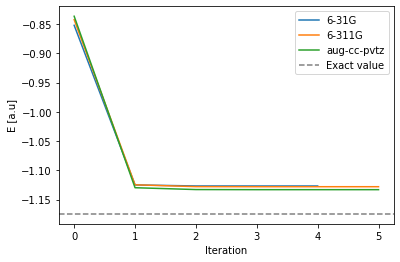

In [10]:
fig, ax = plt.subplots(1)

ax.plot(basis6_31G.index, basis6_31G['Total Energy'], label='6-31G')
ax.plot(basis6_311G.index,basis6_311G['Total Energy'],label='6-311G')
ax.plot(basisCC.index, basisCC['Total Energy'], label='aug-cc-pvtz')
#ax.set_ylim(ax.get_ylim()[::-1])
ax.axhline(-1.174474, label='Exact value', linestyle='--', color='gray')
ax.set_xlabel('Iteration')
ax.set_ylabel('E [a.u]')
ax.legend()
plt.show()

Try to find out why we are using Guess=Mix for the UHF runs. You may use the Gaussian manual on gaussian.com (or Google…)

psi4 uses SAD as default which is similar to Guess=Mix in gaussian
> Superposition of Atomic Densities. Builds the initial density as the spin-averaged sum of atomic UHF computations in the current basis. If an open-shell system, uniform scaling of the spin-averaged density matrices is performed. If orbitals are needed (e.g., in density fitting), a partial Cholesky factorization of the density matrices is used. Often extremely accurate, particularly for closed-shell systems.
From [PSI4 Docs](https://psicode.org/psi4manual/master/scf.html#initial-guess)

In [11]:
energies_RHF = []


distances = [0.50,0.60,0.80,1.00,1.50,2.50,4.00, 5.00, 6.00]

for dist in distances:
    h2 = psi4.geometry(f"""
0 1
symmetry c1
H 0.0 0.0 0.0
H 0.0 0.0 {dist}
""")
 
    psi4.core.set_output_file(f'dissociationcurve_RHF.log', True)
    psi4.set_options({'reference':'rhf', 'guess_mix': "False"})
    E_RHF = psi4.energy('scf/6-31G', molecule=h2)
    print(dist, E_RHF)
    psi4.core.clean()

    energies_RHF.append(E_RHF)
    
psi4.core.clean()

0.5 -1.05802711057592
0.6 -1.1100324287663765
0.8 -1.1237141133789414
1.0 -1.094809823732873
1.5 -0.9975015291244913
2.5 -0.8569176478671185
4.0 -0.7702058566356165
5.0 -0.7513896233586692
6.0 -0.7418516911771098


In [14]:
energies_UHF = []


distances = [0.50,0.60,0.80,1.00,1.50,2.50,4.00, 5.00, 6.00]

for dist in distances:
    h2 = psi4.geometry(f"""
symmetry c1
H 0.0 0.0 0.0
H 0.0 0.0 {dist}
""")
    psi4.core.clean()
    psi4.core.set_output_file(f'dissociationcurve_UHF.log', False)
    psi4.set_options({'reference':'uhf', 'guess':'gwh','guess_mix': "True"})
    E_UHF= psi4.energy('scf/6-31G', molecule=h2)
    print(dist, E_UHF)

    energies_UHF.append(E_UHF)
    
psi4.core.clean()   

0.5 -1.0580271105757553
0.6 -1.1100324287663696
0.8 -1.1237141133767192
1.0 -1.0948098236839066
1.5 -1.0187423818039103
2.5 -0.9974080566773112
4.0 -0.9964851386952827
5.0 -0.9964663314978484
6.0 -0.996465867278455


In [15]:
h = psi4.geometry(f"""
symmetry c1
H 0.0 0.0 0.0
""")
psi4.set_options({'reference':'uhf', 'guess':'gwh','guess_mix': "True"})
psi4.core.set_output_file(f'single_UHF.log', True)
E_H_UHF = psi4.energy('hf/6-31G', molecule=h)
psi4.core.clean()

In [19]:
atomicunitToKcal = 630  # 1 a.u = 630 kcal/mol

In [22]:
E_inter_RHF =  (np.array(energies_RHF)-2*E_H_UHF)*atomicunitToKcal

E_inter_UHF =  (np.array(energies_UHF)-2*E_H_UHF)*atomicunitToKcal
    

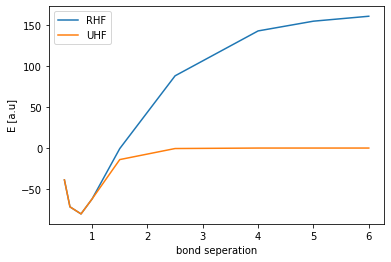

In [23]:
fig, ax = plt.subplots(1)

ax.plot(distances,E_inter_RHF, label='RHF')
ax.plot(distances,E_inter_UHF,label='UHF')

ax.set_xlabel('bond seperation')
ax.set_ylabel('E [kcal mol]')
ax.legend()
plt.show()

# H2O Geometry Opt

In [191]:
h2o_suboptimal = psi4.geometry(f"""
0 1
O 0.0000 0.0000 0.0000
H 1.4000 0.0000 0.0000
H 0.0000 1.4000 0.0000
""")
psi4.set_options({'reference':'uhf'})
psi4.core.set_output_file(f'h2o.log', True)


In [192]:
psi4.energy('hf/6-31G', molecule=h2o)

-75.98534361044706

In [193]:
!rm h2o-opt.log

In [194]:
psi4.set_module_options('optking',{'print_trajectory_xyz_file':True})

In [195]:
psi4.core.set_output_file(f'h2o-opt.log', True)
E = psi4.optimize('hf/6-31G', molecule=h2o_suboptimal)

Optimizer: Optimization complete!


In [96]:
!cat h2o-opt.log


Error: option XZY_FILE is not contained in the list of available options.

Did you mean? 

gradient() will perform analytic gradient computation.

*** tstart() called on lcbcpc67
*** at Wed May 19 15:55:07 2021

   => Loading Basis Set <=

    Name: 6-31G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   117 file /home/duerr/miniconda3/envs/iesm/share/psi4/basis/6-31g.gbs 
    atoms 2-3 entry H          line    26 file /home/duerr/miniconda3/envs/iesm/share/psi4/basis/6-31g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              UHF Reference
                       20 Threads,   7629 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c2v
    Full point group: C2v

    Geometry (in Angstrom), cha

In [202]:
def readXYZ(file):
    f = open(file, "r")
    lines = f.readlines()
    filelength = len(lines)
    new=True
    molecules = []
    for line in lines:
        if new:
            nAtoms=int(line)
            molecule = []
            added=0
            new=False
            continue
        if 'Geometry for iteration' in line:
            continue
        if added<=nAtoms:
            coord = list(filter(None, line.replace('\t','').replace('\n','').split(' ')))[1:]
            coord = [float(x) for x in coord]
            molecule.append(coord)
            added+=1
            if added==nAtoms:
                new=True
                molecules.append(np.array(molecule))
    return molecules


In [250]:
def readXYZ_viewing(file):
    f = open(file, "r")
    lines = f.readlines()
    filelength = len(lines)
    new=True
    molecules = []
    for line in lines:
        if new:
            nAtoms=int(line)
            molecule = ""
            added=0
            new=False
            continue
        if 'Geometry for iteration' in line:
            continue
        if added<=nAtoms:
            coord = str(line.replace('\t   ',''))
            molecule+=coord
            added+=1
            if added==nAtoms:
                new=True
                
                molecules.append(f"{nAtoms}\n\n"+molecule)
    return molecules[1:]

In [251]:
optimized_geos = readXYZ_viewing('geoms.xyz')
optimized_geos

['3\n\n O     0.0000000000   0.0000000000  -0.0114544075\n H     0.8748571714   0.0000000000   0.8294915860\n H    -0.8748571714  -0.0000000000   0.8294915860\n',
 '3\n\n O     0.0000000000   0.0000000000   0.0142967391\n H     0.7746339463   0.0000000000   0.6926260775\n H    -0.7746339463  -0.0000000000   0.6926260775\n',
 '3\n\n O     0.0000000000   0.0000000000   0.0500600932\n H     0.7204274882   0.0000000000   0.5394265788\n H    -0.7204274882  -0.0000000000   0.5394265788\n',
 '3\n\n O     0.0000000000   0.0000000000  -0.0899558994\n H     0.7988097054   0.0000000000   0.4521933530\n H    -0.7988097054  -0.0000000000   0.4521933530\n',
 '3\n\n O     0.0000000000  -0.0000000000  -0.0514455088\n H     0.7844573560   0.0000000000   0.4768601594\n H    -0.7844573560  -0.0000000000   0.4768601594\n',
 '3\n\n O     0.0000000000   0.0000000000  -0.0621518633\n H     0.7848349732   0.0000000000   0.4706937070\n H    -0.7848349732  -0.0000000000   0.4706937070\n',
 '3\n\n O     0.000000

In [203]:
optimized_geometries = readXYZ('geoms.xyz')

In [204]:
optimized_geometries

[array([[ 0.        ,  0.        , -0.11079007],
        [ 0.98994949,  0.        ,  0.87915942],
        [-0.98994949, -0.        ,  0.87915942]]),
 array([[ 0.        ,  0.        , -0.01145441],
        [ 0.87485717,  0.        ,  0.82949159],
        [-0.87485717, -0.        ,  0.82949159]]),
 array([[ 0.        ,  0.        ,  0.01429674],
        [ 0.77463395,  0.        ,  0.69262608],
        [-0.77463395, -0.        ,  0.69262608]]),
 array([[ 0.        ,  0.        ,  0.05006009],
        [ 0.72042749,  0.        ,  0.53942658],
        [-0.72042749, -0.        ,  0.53942658]]),
 array([[ 0.        ,  0.        , -0.0899559 ],
        [ 0.79880971,  0.        ,  0.45219335],
        [-0.79880971, -0.        ,  0.45219335]]),
 array([[ 0.        , -0.        , -0.05144551],
        [ 0.78445736,  0.        ,  0.47686016],
        [-0.78445736, -0.        ,  0.47686016]]),
 array([[ 0.        ,  0.        , -0.06215186],
        [ 0.78483497,  0.        ,  0.47069371],
        

In [205]:
def angle_distances(coordinates):
    O=coordinates[0]
    H1=coordinates[1]
    H2=coordinates[2]
    OH1=O-H1
    OH2=O-H2
    unit_vector_1 = OH1 / np.linalg.norm(OH1)
    unit_vector_2 = OH2 / np.linalg.norm(OH2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return angle*180/np.pi, np.linalg.norm(OH1), np.linalg.norm(OH2)
    

In [217]:
angle_dist = []
for coords in optimized_geometries:
    angle_dist.append(angle_distances(coords))

h2o_angles_dist = np.array(angle_dist[1:])

In [218]:
geo_opt_energies = !grep '@DF-UHF Final Energy' h2o-opt.log
geo_opt_energies = [float(x.replace('  @DF-UHF Final Energy:   ',''))  for x in geo_opt_energies]
geo_opt_energies

[-75.81433131347029,
 -75.90248964217477,
 -75.97144468402449,
 -75.9696787890953,
 -75.98483650050727,
 -75.98531002827575,
 -75.98534164130469,
 -75.98534375998918]

In [223]:
h2o_angles_dist[:,1]

array([1.21349299, 1.02965453, 0.87091637, 0.96541326, 0.94576965,
       0.9486255 , 0.94967435, 0.94967435])

In [219]:
# Water complete PES

In [12]:
h2o = psi4.geometry(f"""
0 1
O  
H       1        0.97000
H       1        0.97000     2      109.47100
""")
psi4.set_options({'reference':'uhf'})
psi4.core.set_output_file(f'h2o.log', True)
psi4.energy('hf/6-31G', molecule=h2o)

-75.98450767925118

In [39]:
distances = np.linspace(0.6, 2, 40)
angles = np.linspace(20, 170, 40)

energies =  np.zeros((40,40))

In [40]:
for i,dist in enumerate(distances):
    for j,ang in enumerate(angles):
        print(dist, ang)
        h2o = psi4.geometry(f"""
        0 1
        O  
        H       1        {dist}
        H       1        {dist}     2      {ang}
        """)
        psi4.set_options({'reference':'uhf'})
        psi4.core.set_output_file(f'h2o.log', True)
        energies[i,j] =  psi4.energy('hf/6-31G', molecule=h2o)
         

0.6 20.0
0.6 23.846153846153847
0.6 27.692307692307693
0.6 31.53846153846154
0.6 35.38461538461539
0.6 39.230769230769226
0.6 43.07692307692308
0.6 46.92307692307692
0.6 50.769230769230774
0.6 54.61538461538461
0.6 58.46153846153846
0.6 62.30769230769231
0.6 66.15384615384616
0.6 70.0
0.6 73.84615384615384
0.6 77.6923076923077
0.6 81.53846153846155
0.6 85.38461538461539
0.6 89.23076923076923
0.6 93.07692307692308
0.6 96.92307692307692
0.6 100.76923076923077
0.6 104.61538461538461
0.6 108.46153846153847
0.6 112.3076923076923
0.6 116.15384615384616
0.6 120.0
0.6 123.84615384615385
0.6 127.6923076923077
0.6 131.53846153846155
0.6 135.3846153846154
0.6 139.23076923076923
0.6 143.0769230769231
0.6 146.9230769230769
0.6 150.76923076923077
0.6 154.6153846153846
0.6 158.46153846153845
0.6 162.30769230769232
0.6 166.15384615384616
0.6 170.0
0.6358974358974359 20.0
0.6358974358974359 23.846153846153847
0.6358974358974359 27.692307692307693
0.6358974358974359 31.53846153846154
0.6358974358974359 

0.8153846153846154 35.38461538461539
0.8153846153846154 39.230769230769226
0.8153846153846154 43.07692307692308
0.8153846153846154 46.92307692307692
0.8153846153846154 50.769230769230774
0.8153846153846154 54.61538461538461
0.8153846153846154 58.46153846153846
0.8153846153846154 62.30769230769231
0.8153846153846154 66.15384615384616
0.8153846153846154 70.0
0.8153846153846154 73.84615384615384
0.8153846153846154 77.6923076923077
0.8153846153846154 81.53846153846155
0.8153846153846154 85.38461538461539
0.8153846153846154 89.23076923076923
0.8153846153846154 93.07692307692308
0.8153846153846154 96.92307692307692
0.8153846153846154 100.76923076923077
0.8153846153846154 104.61538461538461
0.8153846153846154 108.46153846153847
0.8153846153846154 112.3076923076923
0.8153846153846154 116.15384615384616
0.8153846153846154 120.0
0.8153846153846154 123.84615384615385
0.8153846153846154 127.6923076923077
0.8153846153846154 131.53846153846155
0.8153846153846154 135.3846153846154
0.8153846153846154 

0.9948717948717949 143.0769230769231
0.9948717948717949 146.9230769230769
0.9948717948717949 150.76923076923077
0.9948717948717949 154.6153846153846
0.9948717948717949 158.46153846153845
0.9948717948717949 162.30769230769232
0.9948717948717949 166.15384615384616
0.9948717948717949 170.0
1.0307692307692307 20.0
1.0307692307692307 23.846153846153847
1.0307692307692307 27.692307692307693
1.0307692307692307 31.53846153846154
1.0307692307692307 35.38461538461539
1.0307692307692307 39.230769230769226
1.0307692307692307 43.07692307692308
1.0307692307692307 46.92307692307692
1.0307692307692307 50.769230769230774
1.0307692307692307 54.61538461538461
1.0307692307692307 58.46153846153846
1.0307692307692307 62.30769230769231
1.0307692307692307 66.15384615384616
1.0307692307692307 70.0
1.0307692307692307 73.84615384615384
1.0307692307692307 77.6923076923077
1.0307692307692307 81.53846153846155
1.0307692307692307 85.38461538461539
1.0307692307692307 89.23076923076923
1.0307692307692307 93.0769230769

1.2102564102564102 96.92307692307692
1.2102564102564102 100.76923076923077
1.2102564102564102 104.61538461538461
1.2102564102564102 108.46153846153847
1.2102564102564102 112.3076923076923
1.2102564102564102 116.15384615384616
1.2102564102564102 120.0
1.2102564102564102 123.84615384615385
1.2102564102564102 127.6923076923077
1.2102564102564102 131.53846153846155
1.2102564102564102 135.3846153846154
1.2102564102564102 139.23076923076923
1.2102564102564102 143.0769230769231
1.2102564102564102 146.9230769230769
1.2102564102564102 150.76923076923077
1.2102564102564102 154.6153846153846
1.2102564102564102 158.46153846153845
1.2102564102564102 162.30769230769232
1.2102564102564102 166.15384615384616
1.2102564102564102 170.0
1.2461538461538462 20.0
1.2461538461538462 23.846153846153847
1.2461538461538462 27.692307692307693
1.2461538461538462 31.53846153846154
1.2461538461538462 35.38461538461539
1.2461538461538462 39.230769230769226
1.2461538461538462 43.07692307692308
1.2461538461538462 46.92

1.4256410256410255 58.46153846153846
1.4256410256410255 62.30769230769231
1.4256410256410255 66.15384615384616
1.4256410256410255 70.0
1.4256410256410255 73.84615384615384
1.4256410256410255 77.6923076923077
1.4256410256410255 81.53846153846155
1.4256410256410255 85.38461538461539
1.4256410256410255 89.23076923076923
1.4256410256410255 93.07692307692308
1.4256410256410255 96.92307692307692
1.4256410256410255 100.76923076923077
1.4256410256410255 104.61538461538461
1.4256410256410255 108.46153846153847
1.4256410256410255 112.3076923076923
1.4256410256410255 116.15384615384616
1.4256410256410255 120.0
1.4256410256410255 123.84615384615385
1.4256410256410255 127.6923076923077
1.4256410256410255 131.53846153846155
1.4256410256410255 135.3846153846154
1.4256410256410255 139.23076923076923
1.4256410256410255 143.0769230769231
1.4256410256410255 146.9230769230769
1.4256410256410255 150.76923076923077
1.4256410256410255 154.6153846153846
1.4256410256410255 158.46153846153845
1.4256410256410255

1.6051282051282052 166.15384615384616
1.6051282051282052 170.0
1.641025641025641 20.0
1.641025641025641 23.846153846153847
1.641025641025641 27.692307692307693
1.641025641025641 31.53846153846154
1.641025641025641 35.38461538461539
1.641025641025641 39.230769230769226
1.641025641025641 43.07692307692308
1.641025641025641 46.92307692307692
1.641025641025641 50.769230769230774
1.641025641025641 54.61538461538461
1.641025641025641 58.46153846153846
1.641025641025641 62.30769230769231
1.641025641025641 66.15384615384616
1.641025641025641 70.0
1.641025641025641 73.84615384615384
1.641025641025641 77.6923076923077
1.641025641025641 81.53846153846155
1.641025641025641 85.38461538461539
1.641025641025641 89.23076923076923
1.641025641025641 93.07692307692308
1.641025641025641 96.92307692307692
1.641025641025641 100.76923076923077
1.641025641025641 104.61538461538461
1.641025641025641 108.46153846153847
1.641025641025641 112.3076923076923
1.641025641025641 116.15384615384616
1.641025641025641 12

1.8205128205128203 123.84615384615385
1.8205128205128203 127.6923076923077
1.8205128205128203 131.53846153846155
1.8205128205128203 135.3846153846154
1.8205128205128203 139.23076923076923
1.8205128205128203 143.0769230769231
1.8205128205128203 146.9230769230769
1.8205128205128203 150.76923076923077
1.8205128205128203 154.6153846153846
1.8205128205128203 158.46153846153845
1.8205128205128203 162.30769230769232
1.8205128205128203 166.15384615384616
1.8205128205128203 170.0
1.8564102564102565 20.0
1.8564102564102565 23.846153846153847
1.8564102564102565 27.692307692307693
1.8564102564102565 31.53846153846154
1.8564102564102565 35.38461538461539
1.8564102564102565 39.230769230769226
1.8564102564102565 43.07692307692308
1.8564102564102565 46.92307692307692
1.8564102564102565 50.769230769230774
1.8564102564102565 54.61538461538461
1.8564102564102565 58.46153846153846
1.8564102564102565 62.30769230769231
1.8564102564102565 66.15384615384616
1.8564102564102565 70.0
1.8564102564102565 73.846153

In [41]:
e_flattened = []
d = []
a = []

for i,dist in enumerate(distances):
    for j,ang in enumerate(angles):
        e_flattened.append(energies[j,i])
        d.append(dist)
        a.append(ang)

In [230]:
np.save('water-hf-6-31G-energies', energies)
np.save('water-hf-6-31G-energies2', e2)
np.save('water-hf-6-31G-distances', distances)
np.save('water-hf-6-31G-angle', angles)

In [43]:
import plotly.graph_objects as go


In [228]:
e2 = np.zeros((40,40))
for i,dist in enumerate(distances):
    for j,ang in enumerate(angles):
        e2[j,i] = energies[i,j]

In [253]:
fig = go.Figure(data=[go.Surface(z=e2, x=distances, y=angles, colorscale='RdBu',reversescale=True)  
                     ])
fig.add_scatter3d(z=geo_opt_energies, x=h2o_angles_dist[:,1], y=h2o_angles_dist[:,0],mode='markers+lines', marker=dict(
        size=3,
        color='orange',
        
        opacity=1
    ),
                   line=dict(
        color='darkorange',
        width=2
    )
                 )

fig.update_layout(title='Water Potential Energy Surface', autosize=False,
                  template='simple_white',
                  width=900, height=900,
                  scene = dict(
                   xaxis_title="O-H [A]",
                  yaxis_title="Angle H-O-H",
                    zaxis_title='Energy [a.u]',
                  xaxis_showspikes=False,
                yaxis_showspikes=False),
                  
                  #zaxis_title="Energy",
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()
fig.write_html('water_pes_6-31G.html', include_mathjax='cdn')

In [252]:
# Draws XYZ list geometries based on their input number, useful for interact
def drawXYZGeomNum(geom, conf):
    view = p3d.view(width=400, height=400)
    view.addModel(geom[conf], "xyz")
    view.setStyle({'stick':{}})
    view.zoomTo()
    return(view.show())

def drawXYZGeomSlider(geom):
    interact(drawXYZGeomNum, geom=fixed(geom), conf=widgets.IntSlider(min=0, max=len(geom)-1, step=1))


drawXYZGeomSlider(optimized_geos)

interactive(children=(IntSlider(value=0, description='conf', max=7), Output()), _dom_classes=('widget-interact…